In this example we will perform an analysis for the app focusing on investigation why people remove app. Our negative target even in this case will be "app_remove".

In [1]:
from retentioneering import init_config
import pandas as pd


init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='not_remove', # name of positive target event
    pos_target_definition={},
    negative_target_event='app_remove', # name of positive target event
)

In [2]:
data = pd.read_csv('data/mobile-app-data.zip')
data = data.sort_values('event_timestamp')
# adds positive event
data = data.retention.prepare()

Firstly, we need to filter and aggregate events.

To remove specific event simply click on the blue checkbox for selected event. To aggregare group of events to single parent event click on the smaller gray checkbox near parent event.

Now let's remove system events, screen_view, os events, user_engagement, from app we need just app_remove, 

In [3]:
data.retention.show_tree_selector()

After that you need to download created filter with using "Download Filter" link.

Now you can use this filter using next chunk.

Below you can upload filter file we created for the cases we illustrate later in this notebook

In [4]:
data = data.retention.use_tree_filter('filter_list.json')

Lets split data into sessions

In [5]:
data.retention.split_sessions(by_event='session_start')
data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)

# Analysis

## Step matrix

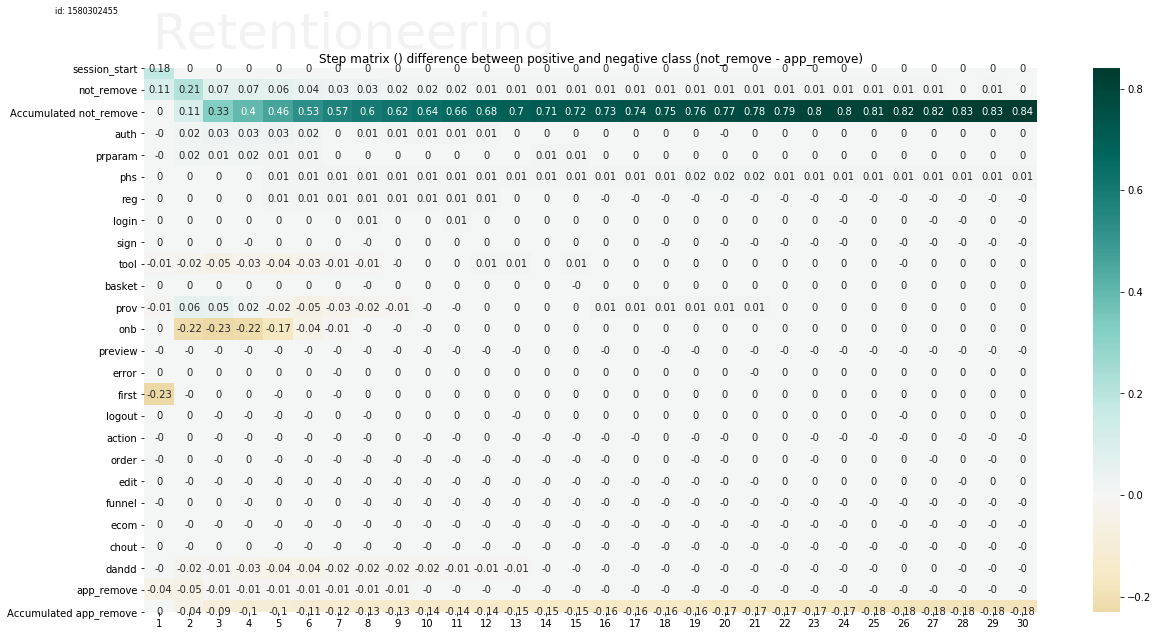

In [6]:
f = data.retention.create_filter(index_col='user_session')
data.retention.get_step_matrix_difference(f, index_col='user_session');

From previous plot we can see that in sessions with removed app, users significantly slows down on onboarding (onb group) and on catalogue (prov group).

This is our first hypothesis about app problems.

## Clustering

/usr/local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



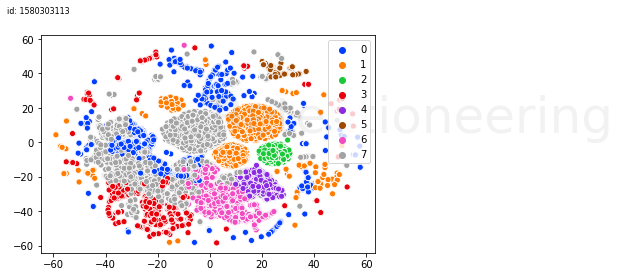

In [7]:
data.retention.learn_tsne(index_col='user_session', plot_type='clusters');

We can choose cluster from center and visualize it

We can see problems with catalogue for zero cluster: a lot of users move from app after first prov event.

In [8]:
data.retention.get_clusters(index_col='user_session');

In [9]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', thresh=0.05))

/Users/anatolyzaytsev/Library/Python/3.7/lib/python/site-packages/networkx-2.4rc1-py3.7.egg/networkx/drawing/layout.py:950: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



'mobile-app/index_2020-01-29 16_05_40_295173.html'

Selection process involves multiple steps were users edit their selected products and select different kind of options (node "param"). Users can do this without authorization. But after they add selected and customized products to cart they are asked to authorize.

In this cluster we can clearly see the problem with autorization: after authorization we need to return to catalogue (node "prov") and start selection and customization process all over again (node "prparam").

We can see from graph that there is no way to return after authorization to previous step in catalogue (no edge from "auth" to "prparam").

This is a problem in app: authorization brokes user trajectory, so user should return in the beginning.

We can see problems with detailed events via `dump_event_col` column.

In [10]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', cols=['dump_event_col', 'dump_event_col_shift'], thresh=0.08, width=800, height=800))

'mobile-app/index_2020-01-29 16_05_40_675302.html'

This graph can support our hypothesis about bad catalogue organization with `prov_click_category_other` event. We can see that users often remove app after this event, wich redirects users to web-page. It's clear example of not optimal app organization where web-page link cannibiling users from mobile app.

# Predict app remove

In [7]:
# train test split
data_train , data_test = data.retention.index_based_split(index_col='user_pseudo_id')

In [8]:
# select group of users with trajectories longer > 20
min_length = 20

users_grouped = data.groupby(data.user_pseudo_id).agg({
    'event_timestamp':'count'
})

good_users_list = users_grouped[users_grouped['event_timestamp'] > min_length].index.values.tolist()

#keep only users with trajectories longer than min_length
data_test_clean = data_test[data_test.apply(lambda x: x['user_pseudo_id'] in good_users_list, axis=1)]
data_train_clean = data_train[data_train.apply(lambda x: x['user_pseudo_id'] in good_users_list, axis=1)]


In [9]:
# create model on train
model = data_train_clean.retention.create_model()

# extract features for test 
# parameter wo_last_k - how many steps in advance you want to predict
features_test = data_train_clean.retention.extract_features_from_test(data_test_clean, ngram_range=(1,2),wo_last_k=0)

# add targets to test
target = features_test.index.isin(data_test_clean.retention.get_positive_users())

c:\users\mi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mi\AppData\Roaming\Python\Python36\site-packages\pandas-0.24.2-py3.6-win-amd64.egg\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [10]:
# make prediction and visualize the features importance
model.permutation_importance(features_test, target, thresh=0.6)


            ROC-AUC: 0.7141610867520931
            PR-AUC: 0.7828617829380533
            Accuracy: 0.6823385118560916
            


C:\Users\mi\AppData\Roaming\Python\Python36\site-packages\retentioneering-1.0.0-py3.6.egg\retentioneering\visualization\plot.py:291: RuntimeWarning: divide by zero encountered in log1p
